In [49]:
import numpy as np
import sys
import re
import os
import pandas as pd
import warnings
from pathlib import Path
from typing import List, Dict, Tuple, Any, Union, Callable
from tqdm import tqdm
import csv
import json
from dataclasses import dataclass

import matplotlib.pyplot as plt
import seaborn as sns
from corner import corner

plt.rcParams['figure.figsize'] = [7, 7]
plt.rcParams['figure.dpi'] = 300


import taurex.log
# taurex.log.disableLogging()
from taurex.cache import OpacityCache, CIACache
from taurex.data.profiles.temperature import Isothermal, Guillot2010, NPoint
from taurex.data import Planet
from taurex.data.stellar import PhoenixStar
from taurex.data.stellar import BlackbodyStar
from taurex.data.profiles.chemistry import TaurexChemistry
from taurex.data.profiles.chemistry import ConstantGas
from taurex.data.profiles.chemistry import TwoLayerGas
from taurex.model import TransmissionModel, EmissionModel
from taurex.contributions import AbsorptionContribution, CIAContribution, RayleighContribution, HydrogenIon
from taurex.data.spectrum.observed import ObservedSpectrum
from astropy.io.fits.verify import VerifyWarning
from taurex.binning.fluxbinner import FluxBinner
from taurex.util.util import wnwidth_to_wlwidth
from taurex.optimizer.nestle import NestleOptimizer

In [4]:
WDIR = Path().cwd().parent

PLANET_DB_PATH = str(WDIR / "data/planet_database_composite.csv")
OPACITY_PATH = str(WDIR / "data/Input/xsec/xsec_sampled_R15000_0.3-15")
CIA_PATH = str(WDIR / "data/Input/cia/hitran")
MOLECULE_PATH = str(WDIR / "data/molecule_db.json")

SPECTRA_BE_PATH = str(WDIR / "data/SpectraBE")
SPECTRA_LW_PATH = str(WDIR / "data/taurex_lightcurves_LW")

OpacityCache().set_opacity_path(OPACITY_PATH)
CIACache().set_cia_path(CIA_PATH)

default_tm_settings = {

}

default_warning_filters = [
    {"category":DeprecationWarning, "module":''},
    {"category":FutureWarning, "module":''},
    {"category":RuntimeWarning, "module":''},
    {"category":Warning, "module":'numpy'},
]

warnings.simplefilter("always")
for f in default_warning_filters:
    warnings.filterwarnings("ignore", **f)

In [5]:
def read_json_file(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

def read_csv_comments(filename: str) -> list:
    lines = []
    with open(filename, 'r') as csvfile:
        csvreader = csv.reader(csvfile)
        for row in csvreader:
            if len(row) > 0 and row[0].startswith("# COLUMN"):
                lines.append(row[0])
    return lines

def process_lines(file_path) -> Dict:

    lines = read_csv_comments(file_path)

    result = {}
    for line in lines:
        key, value = line.replace("# COLUMN", "").split(":", 1)
        result[key.strip()] = value.strip()
    return result


@dataclass
class AliasedDict(dict):
    aliases: dict

    def __init__(self, data: dict, aliases: dict):
        super().__init__(data)
        self.aliases = aliases

    def __getitem__(self, key):
        if key in self.aliases:
            key = self.aliases[key]
        return super().__getitem__(key)

    def __setitem__(self, key, value):
        if key in self.aliases:
            key = self.aliases[key]
        return super().__setitem__(key, value)

    def __delitem__(self, key):
        if key in self.aliases:
            key = self.aliases[key]
        return super().__delitem__(key)

    def add_alias(self, key, alias):
        self.aliases[alias] = key


In [6]:
def get_target_data(planet_name):
    exoplanet_database = pd.read_csv(PLANET_DB_PATH, comment="#", index_col=0)

    target_data = exoplanet_database.loc[exoplanet_database["pl_name"] == planet_name].to_dict(orient="records")[0]

    col_names = process_lines(PLANET_DB_PATH)
    col_names = {v: k for k, v in col_names.items()}

    target = AliasedDict(target_data, aliases=col_names)

    return target

In [7]:
def make_gasses(gas_input_list: Dict = None):
    if gas_input_list is None:
        gas_input_list = read_json_file(MOLECULE_PATH)
    else:
        gas_input_list = [*read_json_file(MOLECULE_PATH), *gas_input_list]

    h2_gas = TwoLayerGas(
        'H',
        mix_ratio_surface=1e-2,
        mix_ratio_top=0.5,
        mix_ratio_P=1e4
    )

    gasses = [h2_gas]

    types = {
        'ConstantGas': ConstantGas,
        'TwoLayerGas': TwoLayerGas,
        'HydrogenIon': HydrogenIon,
    }

    for i, gas in enumerate(gas_input_list):
        gasses.append(
            types[gas["type"]](
                gas["molecule"],
                mix_ratio=10 ** gas["abundance"]
            )
        )

    return gasses, gas_input_list

In [16]:
def build_tm_dynamic(target, settings: (Dict, Any) = None) -> TransmissionModel:
    isothermal = Isothermal(T=target["Equilibrium Temperature [K]"])

    planet = Planet(
        planet_radius=target["Planet Radius [Jupiter Radius]"],
        planet_mass=target["Planet Mass or Mass*sin(i) [Jupiter Mass]"],
    )

    star = BlackbodyStar(
        temperature=target["Stellar Effective Temperature [K]"],
        radius=target["Stellar Radius [Solar Radius]"],
        mass=target["Stellar Mass [Solar mass]"]
    )

    chemistry = TaurexChemistry(
        fill_gases=['H2', 'He'],
        ratio=0.17
    )

    gasses, gas_input_list = make_gasses()

    for gas in gasses:
        chemistry.addGas(gas)

    tm = TransmissionModel(
        planet=planet,
        temperature_profile=isothermal,
        chemistry=chemistry,
        star=star,
        atm_min_pressure=1e-4,
        atm_max_pressure=1e6,
        nlayers=30,
    )

    tm.add_contribution(AbsorptionContribution())

    tm.add_contribution(RayleighContribution())

    tm.add_contribution(CIAContribution(cia_pairs=['H2-H2', 'H2-He']))

    if "e-" in [gas['molecule'] for gas in gas_input_list]:
        tm.add_contribution(HydrogenIon())

    tm.build()

    return tm

In [24]:
target = get_target_data("WASP-121 b")

tm = build_tm_dynamic(target, settings={})

print([k for k, v in tm.fittingParameters.items()])


obs = ObservedSpectrum(SPECTRA_BE_PATH + "/WASP-121b_G141.txt")

obin = obs.create_binner()

opt = NestleOptimizer(num_live_points=50)

opt.set_model(tm)

opt.set_observed(obs)

# for e in tm.fittingParameters:
#     opt.enable_fit(e)

opt.enable_fit('T')
opt.enable_fit('planet_radius')
opt.enable_fit('H2O')
opt.enable_fit('CH4')
opt.enable_fit('CO')
opt.enable_fit('CO2')
opt.enable_fit('Na')
opt.enable_fit('K')



opt.set_boundary('T', [1000, 3500])
opt.set_boundary('planet_radius', [0.8, 2.2])

# opt.set_boundary('planet_distance', [0.95, 2.])
# opt.set_boundary('planet_sma', [0.95, 2.])

# opt.set_boundary('log_H_top', [-16, -0.1])
# opt.set_boundary('log_TiO', [-16, -1])
# opt.set_boundary('log_VO', [-16, -1])
# opt.set_boundary('log_FeH', [-16, -1])
# opt.set_boundary('log_e-', [-16, -1])
# opt.set_boundary('log_He_H2', [-16, -0.5])


solution = opt.fit()
# taurex.log.disableLogging()


taurex.TransmissionModel - INFO - No pressure profile defined, using simple pressure profile with
taurex.TransmissionModel - INFO - parameters nlayers: 30, atm_pressure_range=(0.0001,1000000.0)
taurex.TransmissionModel - INFO - Building model........
taurex.TransmissionModel - INFO - Collecting paramters
taurex.TransmissionModel - INFO - Setting up profiles
taurex.TransmissionModel - INFO - Computing pressure profile
taurex.ChemistryModel - INFO - Initializing chemistry model
taurex.ChemistryModel - INFO - Initializing chemistry model
taurex.TransmissionModel - INFO - Setting up contributions
taurex.TransmissionModel - INFO - DONE
taurex.Nestle - INFO - Initializing parameters
taurex.Nestle - INFO - -------FITTING---------------
taurex.Nestle - INFO - Parameters to be fit:
taurex.Nestle - INFO - planet_radius: Value: 1.7529999999999997 Type:Uniform Params:Bounds = [0.8,2.2]
taurex.Nestle - INFO - T: Value: 2720.0 Type:Uniform Params:Bounds = [1000,3500]
taurex.Nestle - INFO - H2O: Valu

['planet_mass', 'planet_radius', 'planet_distance', 'planet_sma', 'atm_min_pressure', 'atm_max_pressure', 'T', 'H_surface', 'H_top', 'H_P', 'H2O', 'CH4', 'NH3', 'CO', 'CO2', 'HCN', 'Na', 'K', 'TiO', 'VO', 'FeH', 'e-', 'He_H2']
it=   657 logz=200.56439757337niter: 658
ncall: 3006
nsamples: 708
logz: 200.963 +/-  0.469
h: 11.018


taurex.Nestle - INFO - Sampling time 186.53753852844238 s
taurex.Nestle - INFO - Post-processing - Generating spectra and profiles
taurex.Nestle - INFO - Computing solution 0
taurex.TransmissionModel - INFO - Computing pressure profile
taurex.ChemistryModel - INFO - Initializing chemistry model
taurex.Absorption - INFO - Using cross-sections? True
taurex.Absorption - INFO - Recomputing active gas H2O opacity
taurex.Absorption - INFO - Recomputing active gas CH4 opacity
taurex.Absorption - INFO - Recomputing active gas NH3 opacity
taurex.Absorption - INFO - Recomputing active gas CO opacity
taurex.Absorption - INFO - Recomputing active gas CO2 opacity
taurex.Absorption - INFO - Recomputing active gas TiO opacity
taurex.Absorption - INFO - Recomputing active gas VO opacity
taurex.Absorption - INFO - Done
taurex.Rayleigh - INFO - Done
taurex.CIA - INFO - Computing CIA 
taurex.CIA - INFO - Done
taurex.HydrogenIon - INFO - Done
taurex.TransmissionModel - INFO - Computing pressure profile
ta

taurex.TransmissionModel - INFO - Computing pressure profile
taurex.ChemistryModel - INFO - Initializing chemistry model
taurex.Absorption - INFO - Using cross-sections? True
taurex.Absorption - INFO - Recomputing active gas H2O opacity
taurex.Absorption - INFO - Recomputing active gas CH4 opacity
taurex.Absorption - INFO - Recomputing active gas NH3 opacity
taurex.Absorption - INFO - Recomputing active gas CO opacity
taurex.Absorption - INFO - Recomputing active gas CO2 opacity
taurex.Absorption - INFO - Recomputing active gas TiO opacity
taurex.Absorption - INFO - Recomputing active gas VO opacity
taurex.Absorption - INFO - Done
taurex.Rayleigh - INFO - Done
taurex.CIA - INFO - Computing CIA 
taurex.CIA - INFO - Done
taurex.HydrogenIon - INFO - Done


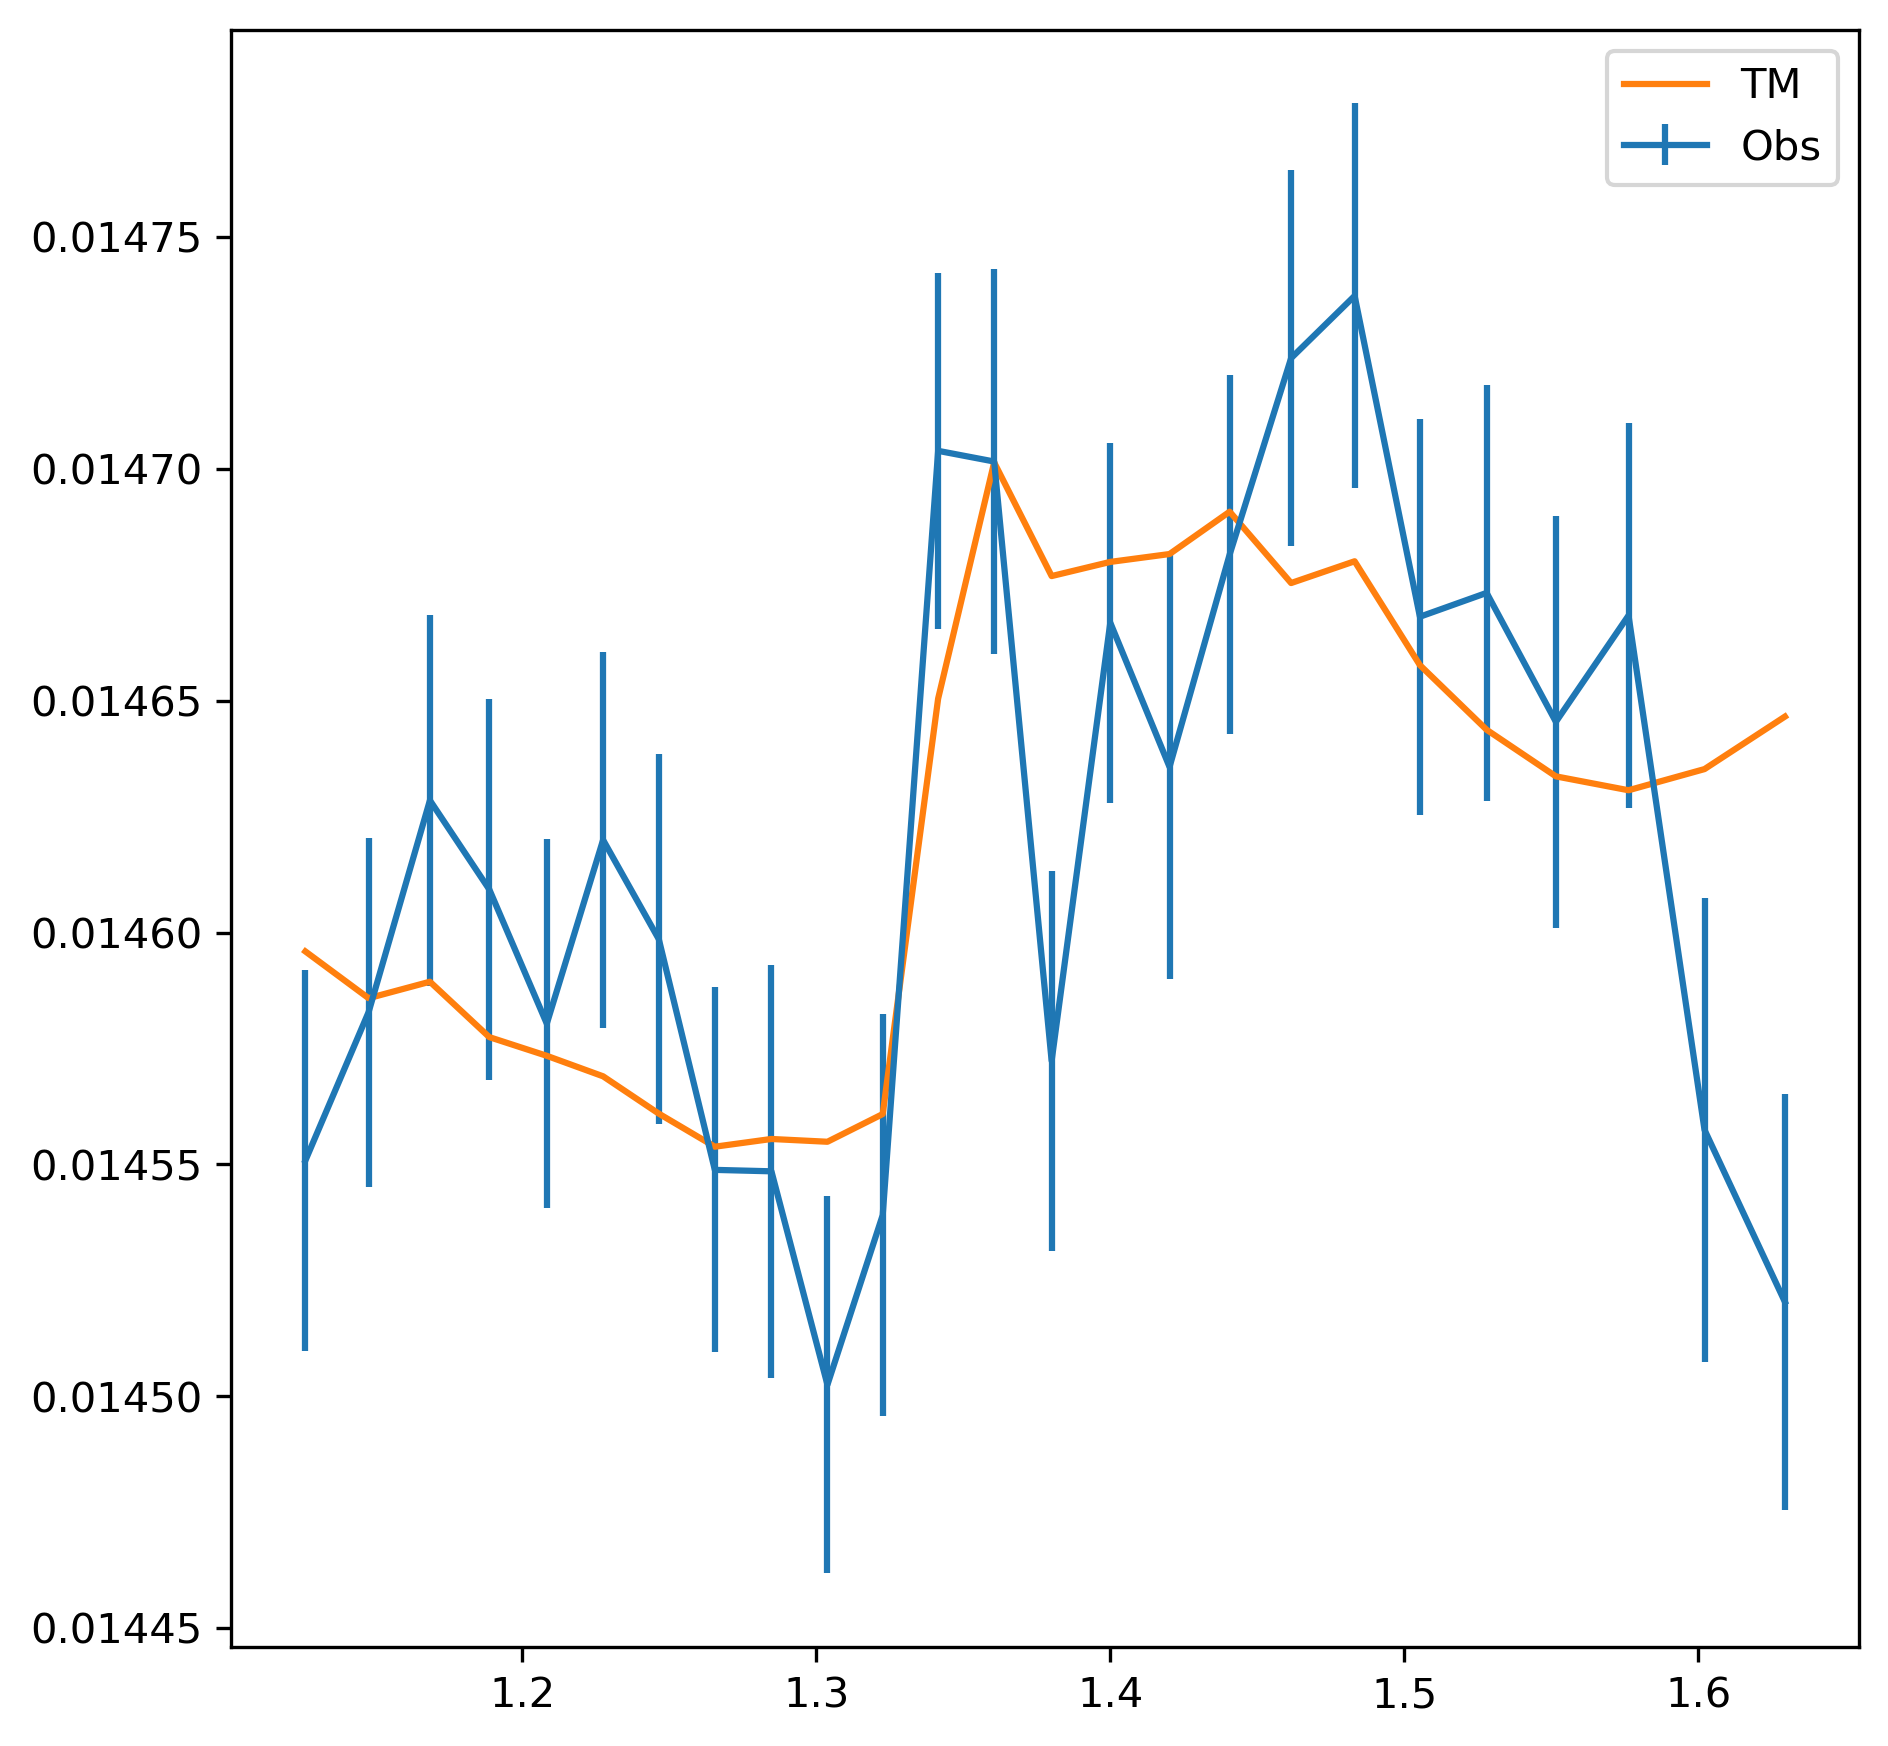

In [25]:
for solution, optimized_map, optimized_value, values in opt.get_solution():
    opt.update_model(optimized_map)
    plt.figure()
    plt.errorbar(obs.wavelengthGrid, obs.spectrum, obs.errorBar, label='Obs')
    plt.plot(obs.wavelengthGrid, obin.bin_model(tm.model(obs.wavenumberGrid))[1], label='TM')
    plt.legend()
    plt.show()

In [45]:
for solution, optimized_map, optimized_value, values in opt.get_solution():
    print("=======================")
    print(solution)
    print(optimized_map)
    print(optimized_value)
    for i, v in enumerate(values):
        print(type(v))
        for k in v:
            print(str(i)+'\t' + str(type(k)))
            if isinstance(k, str):
                print("\t\t"+k)
            if isinstance(k, np.ndarray):
                print("\t\t"+str(k.shape))
            if isinstance(k, dict):
                for p, q in k.items():
                    print("\t\t"+p)
                    if isinstance(q, dict):
                        for ks, vs in q.items():
                            print("\t\t\t"+ks)
                            try:
                                print("\t\t\t"+str(vs.shape))
                            except AttributeError:
                                pass

    #print([[print(k) for k in v] for v in values])

0
[1.694607218029386, 1152.4950683769507, -5.869257068478278, -8.187116789569252, -11.542734826465793, -5.891808683867725, -11.989781818061246, -10.476263848998519]
[1.6946434412477414, 1158.5034204192502, -5.9387194830046734, -9.707187927920447, -8.205814990165335, -8.049245092182714, -7.459357775241068, -7.0864911781549695]
<class 'tuple'>
0	<class 'str'>
		Statistics
0	<class 'dict'>
		Log-Evidence
		Log-Evidence-Error
		Peakiness
<class 'tuple'>
1	<class 'str'>
		fit_params
1	<class 'dict'>
		planet_radius
			mean
			()
			sigma
			(8,)
			value
			sigma_m
			sigma_p
			trace
			(708,)
			map
			()
		T
			mean
			()
			sigma
			(8,)
			value
			sigma_m
			sigma_p
			trace
			(708,)
			map
			()
		log_H2O
			mean
			()
			sigma
			(8,)
			value
			sigma_m
			sigma_p
			trace
			(708,)
			map
			()
		log_CH4
			mean
			()
			sigma
			(8,)
			value
			sigma_m
			sigma_p
			trace
			(708,)
			map
			()
		log_CO
			mean
			()
			sigma
			(8,)
			value
			sigma_m
			sigma_p
			trace
			(

     planet_radius            T   log_H2O    log_CH4     log_CO    log_CO2  \
0         2.092189  2658.982532 -1.790388  -2.276578  -5.445281 -11.649995   
1         2.180945  2227.262980 -5.552040  -6.144027  -6.617343 -10.511228   
2         0.852380  2601.152860 -6.022344  -5.532482  -7.646808  -6.572377   
3         0.829334  2902.024929 -2.592826 -10.903442  -3.364360 -11.027644   
4         0.882308  3182.853017 -7.247995  -5.271061 -11.790197 -10.400063   
..             ...          ...       ...        ...        ...        ...   
703       1.696823  1013.779101 -5.705318 -11.484397  -8.383278  -7.916579   
704       1.694823  1128.859138 -5.901347  -8.035987 -11.771841  -8.082934   
705       1.694575  1138.147939 -5.751243  -9.430364  -5.193549  -7.707044   
706       1.694427  1150.189658 -5.888303  -7.276723  -4.964621  -7.093299   
707       1.696688  1015.265275 -5.683009 -11.774311  -6.087199  -7.918683   

        log_Na      log_K   weights  
0    -7.479455  -2.788380

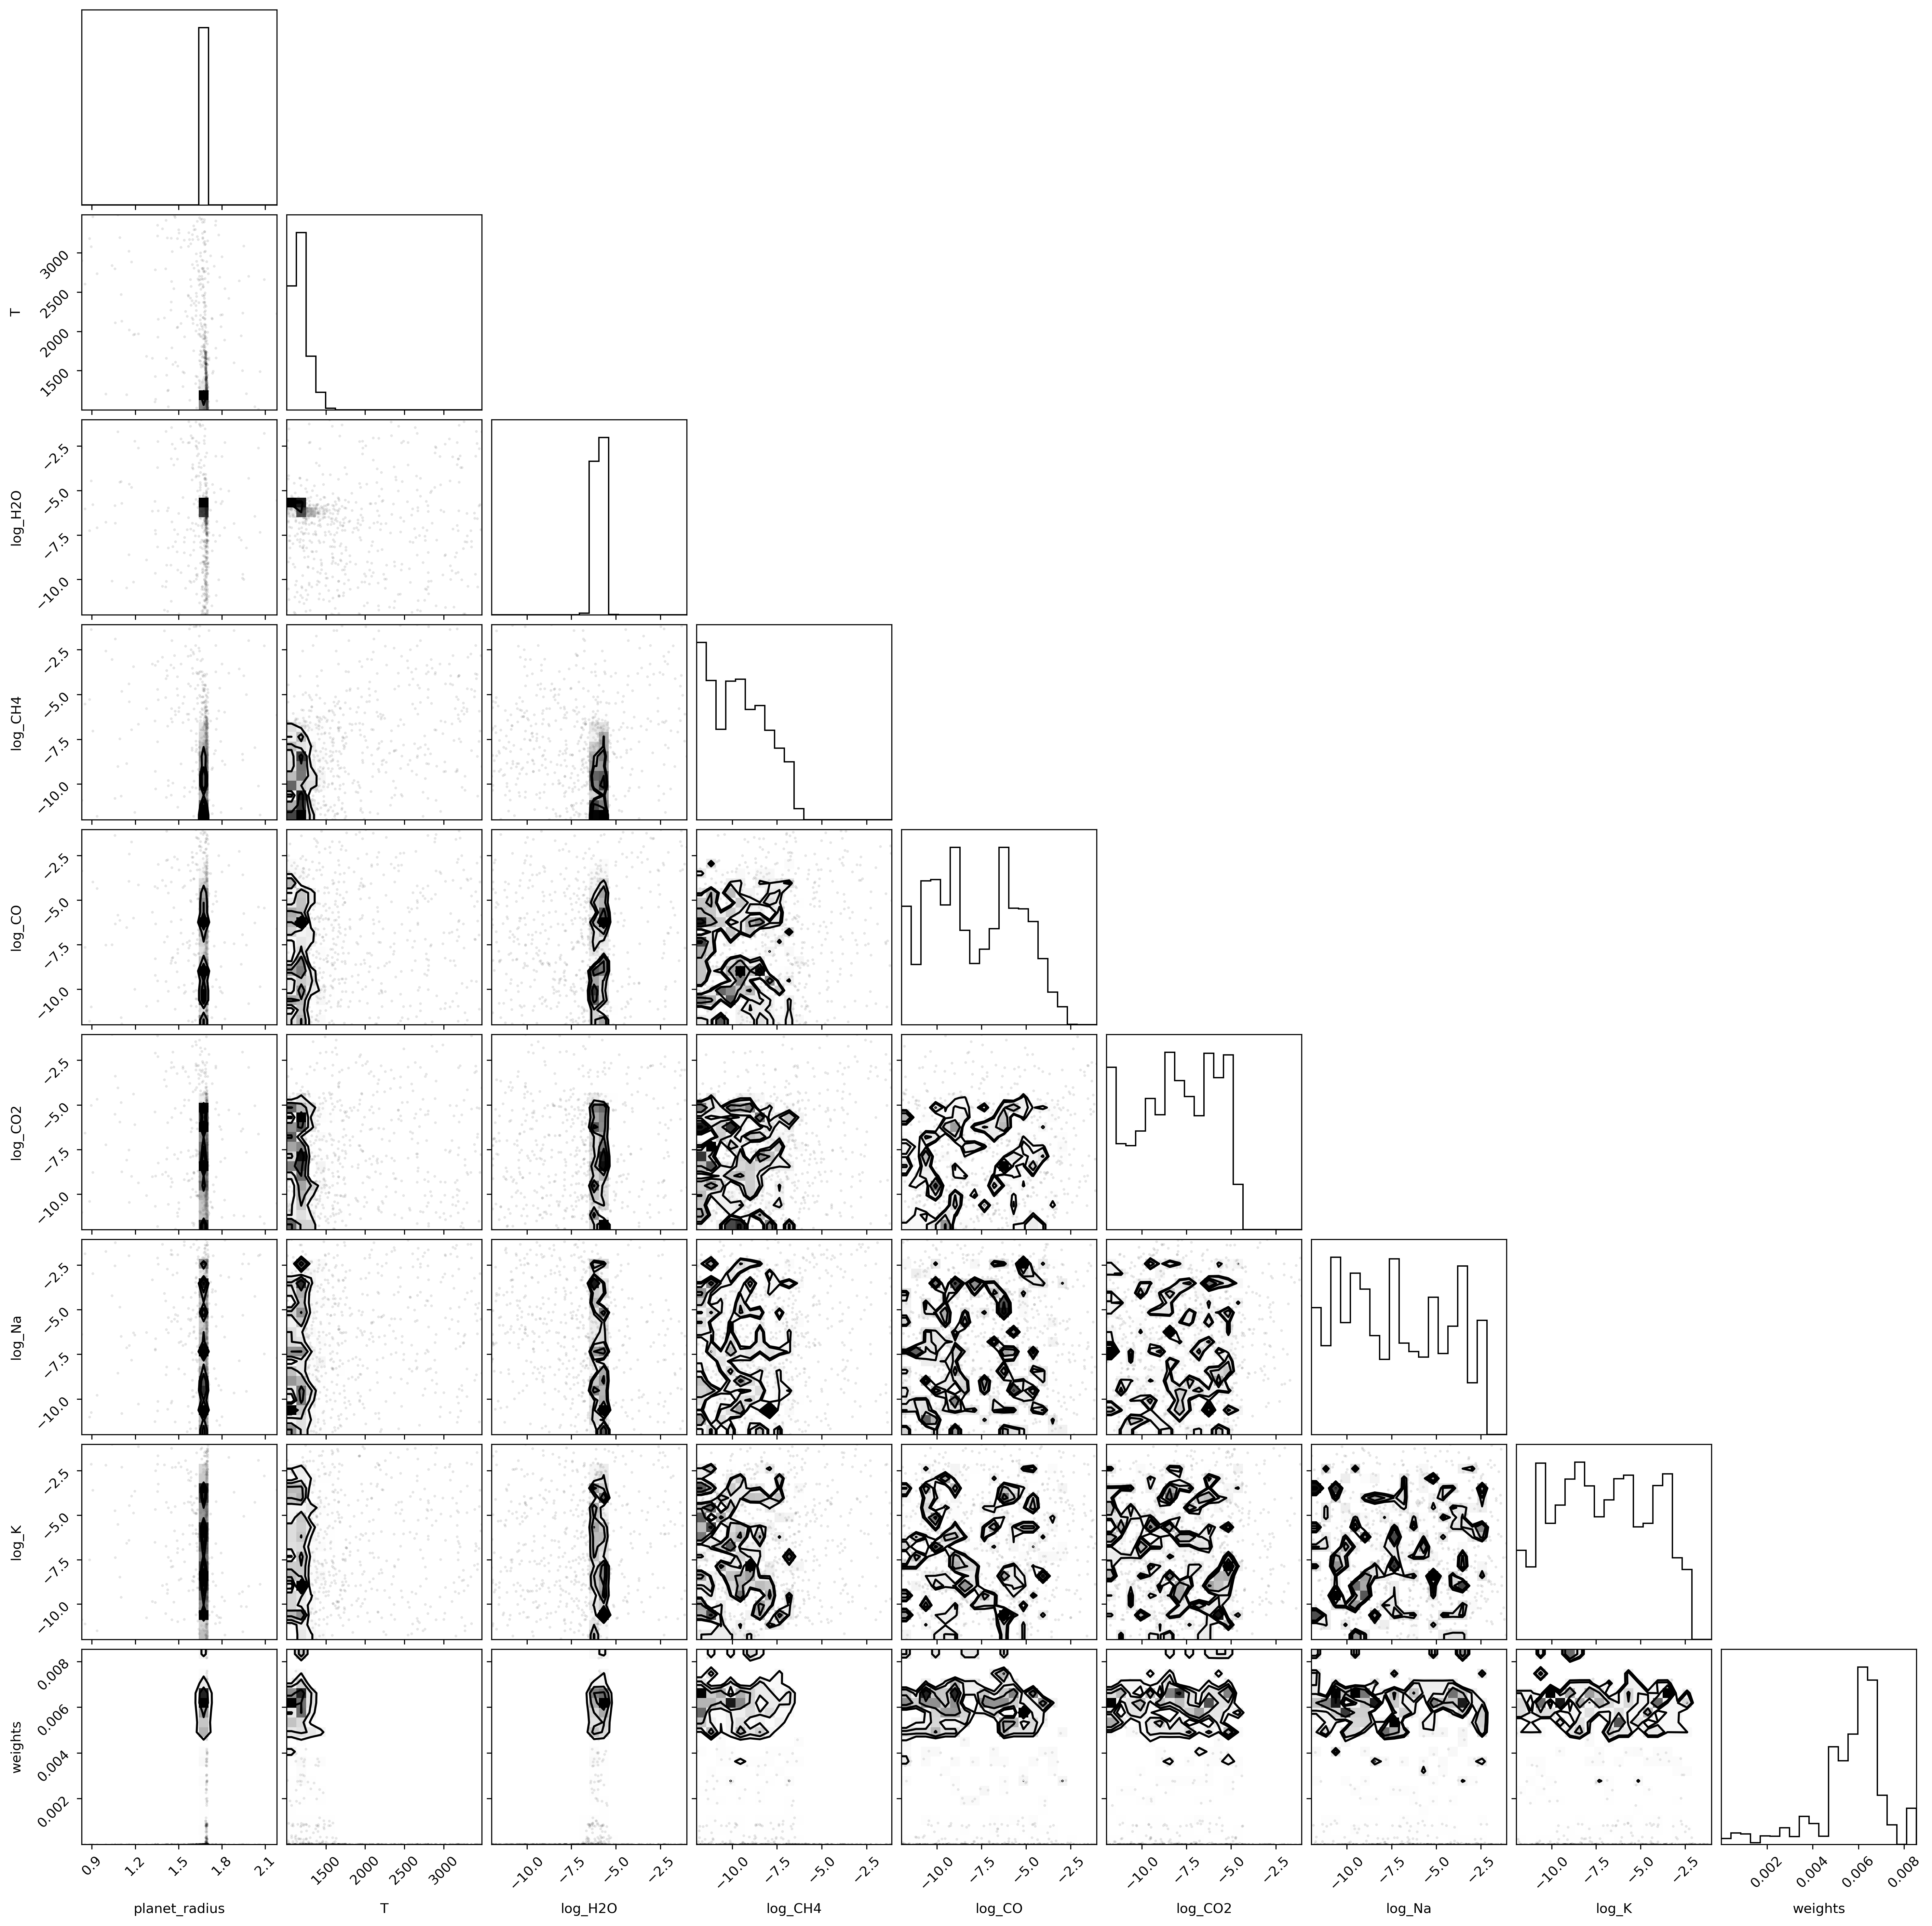

In [51]:
def make_corner(opt):
    for solution, optimized_map, optimized_value, values in opt.get_solution():
        trace = values[2][1]
        keys = values[1][1].keys()

        df = pd.DataFrame(data=trace, columns=keys)
        df["weights"] = values[3][1]

        print(df)

        corner(data=df, bins=20,
               weights=df["weights"])

        # sns.pairplot(data=df,
        #              kind="scatter",
        #              diag_kind="hist",
        #              corner=True)
        #
        # plt.savefig(WDIR / "data/figures" / "corner_test.png", dpi=300)


make_corner(opt)

In [55]:
[print(k, v) for k, v in tm.fittingParameters.items()];

for k,v in tm.fittingParameters.items():
    print(k)
    if isinstance(v, tuple):
        for _v in v:
            try:
                print(_v())
            except TypeError:
                print(_v)

    print("==============")




planet_mass ('planet_mass', '$M_p$', <bound method fitparam.<locals>.wrapper of <taurex.data.planet.Planet object at 0x000001F5EAD04C10>>, <bound method BasePlanet.mass of <taurex.data.planet.Planet object at 0x000001F5EAD04C10>>, 'linear', False, [0.5, 1.5])
planet_radius ('planet_radius', '$R_p$', <bound method fitparam.<locals>.wrapper of <taurex.data.planet.Planet object at 0x000001F5EAD04C10>>, <bound method BasePlanet.radius of <taurex.data.planet.Planet object at 0x000001F5EAD04C10>>, 'linear', True, [0.8, 2.2])
planet_distance ('planet_distance', '$D_{planet}$', <bound method fitparam.<locals>.wrapper of <taurex.data.planet.Planet object at 0x000001F5EAD04C10>>, <bound method BasePlanet.distance of <taurex.data.planet.Planet object at 0x000001F5EAD04C10>>, 'linear', False, [1, 2])
planet_sma ('planet_sma', '$D_{planet}$', <bound method fitparam.<locals>.wrapper of <taurex.data.planet.Planet object at 0x000001F5EAD04C10>>, <bound method BasePlanet.semiMajorAxis of <taurex.data.p

In [56]:

print(tm.fittingParameters)

{'planet_mass': ('planet_mass', '$M_p$', <bound method fitparam.<locals>.wrapper of <taurex.data.planet.Planet object at 0x000001F5EAD04C10>>, <bound method BasePlanet.mass of <taurex.data.planet.Planet object at 0x000001F5EAD04C10>>, 'linear', False, [0.5, 1.5]), 'planet_radius': ('planet_radius', '$R_p$', <bound method fitparam.<locals>.wrapper of <taurex.data.planet.Planet object at 0x000001F5EAD04C10>>, <bound method BasePlanet.radius of <taurex.data.planet.Planet object at 0x000001F5EAD04C10>>, 'linear', True, [0.8, 2.2]), 'planet_distance': ('planet_distance', '$D_{planet}$', <bound method fitparam.<locals>.wrapper of <taurex.data.planet.Planet object at 0x000001F5EAD04C10>>, <bound method BasePlanet.distance of <taurex.data.planet.Planet object at 0x000001F5EAD04C10>>, 'linear', False, [1, 2]), 'planet_sma': ('planet_sma', '$D_{planet}$', <bound method fitparam.<locals>.wrapper of <taurex.data.planet.Planet object at 0x000001F5EAD04C10>>, <bound method BasePlanet.semiMajorAxis o